In [ ]:
#                                    Virtual env: myEnv
%pip install timm

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
from torchvision.datasets import ImageFolder
import timm


c:\Users\Mudasir\anaconda3\envs\myEnv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%pip install split_folders

  Using cached split_folders-0.5.1-py3-none-any.whl.metadata (6.2 kB)
Using cached split_folders-0.5.1-py3-none-any.whl (8.4 kB)
Note: you may need to restart the kernel to use updated packages.


Split Folders

In [1]:
'''
import splitfolders

input_dir = './oc_datasets/final_dataset/complete_dsm'
output_dir = './oc_datasets/final_dataset/train_test_split'

# Split the dataset into train and test with a 80-20 ratio
splitfolders.ratio(input_dir, output=output_dir, seed=42, ratio=(.8, .2), group_prefix=None)
'''


Copying files: 870 files [00:00, 2146.58 files/s]


In [35]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dir = './oc_datasets/final_dataset/train_test_split/train'
val_dir = './oc_datasets/final_dataset/train_test_split/val'

train_dataset = ImageFolder(root=train_dir, transform=transform)
val_dataset = ImageFolder(root=val_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)


In [36]:
model = timm.create_model('hrnet_w18_small', pretrained=True, num_classes=2)  


In [38]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


In [39]:
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

num_epochs = 32

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

        _, predicted_train = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

    epoch_loss =  running_loss/len(train_dataset)
    train_losses.append(epoch_loss)
    train_accuray = correct_train/total_train
    train_accuracies.append(train_accuray)
    
    # Validation loop
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        # total_correct = 0
        # total_samples = 0
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
        
        val_accuracy = correct_val / total_val
        val_loss = running_val_loss / len(val_dataset)
        val_accuracies.append(val_accuracy)
        val_losses.append(val_loss)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuray:.4f},Validation Loss: {val_loss} Validation Accuracy: {val_accuracy:.4f}')


Epoch [1/32], Train Loss: 0.6042, Train Accuracy: 0.6767,Validation Loss: 0.46102907191747905 Validation Accuracy: 0.7759
Epoch [2/32], Train Loss: 0.3498, Train Accuracy: 0.8089,Validation Loss: 0.5321020977250461 Validation Accuracy: 0.7299
Epoch [3/32], Train Loss: 0.2725, Train Accuracy: 0.8463,Validation Loss: 0.6123212973276774 Validation Accuracy: 0.6954
Epoch [4/32], Train Loss: 0.2544, Train Accuracy: 0.8348,Validation Loss: 0.6795047535293404 Validation Accuracy: 0.7184
Epoch [5/32], Train Loss: 0.2347, Train Accuracy: 0.8376,Validation Loss: 0.8034473780927986 Validation Accuracy: 0.7184
Epoch [6/32], Train Loss: 0.2275, Train Accuracy: 0.8448,Validation Loss: 0.9046920051519898 Validation Accuracy: 0.7069
Epoch [7/32], Train Loss: 0.2160, Train Accuracy: 0.8333,Validation Loss: 0.9189753306323084 Validation Accuracy: 0.7241
Epoch [8/32], Train Loss: 0.2116, Train Accuracy: 0.8348,Validation Loss: 0.9402034529324236 Validation Accuracy: 0.7299
Epoch [9/32], Train Loss: 0.214

In [29]:
from sklearn.metrics import confusion_matrix
import numpy as np

In [30]:
import matplotlib.pyplot as plt

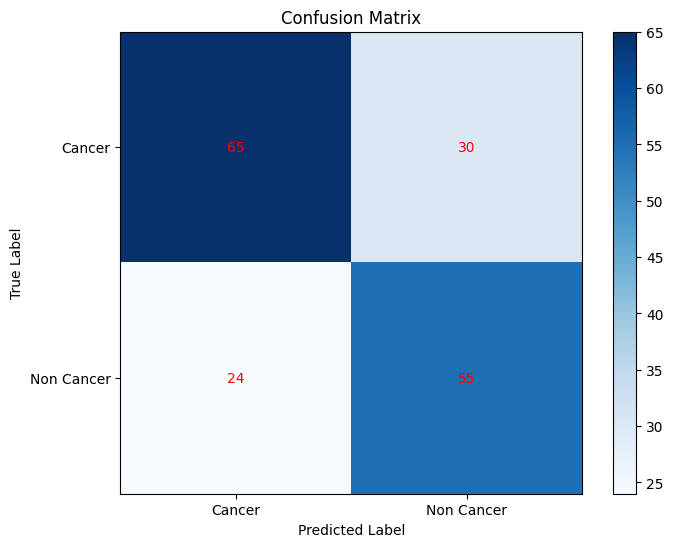

In [31]:
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(np.arange(2), ['Cancer', 'Non Cancer'])  # Modify labels based on your classes
plt.yticks(np.arange(2), ['Cancer', 'Non Cancer'])  # Modify labels based on your classes
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(conf_matrix[i, j]), ha='center', va='center', color='red')

plt.show()

In [32]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve


Evaluation Metrics:
Accuracy: 0.6897
Precision: 0.6471
Recall (Sensitivity): 0.6962
F1 Score: 0.6707
Specificity: 0.6842
AUC: 0.6902


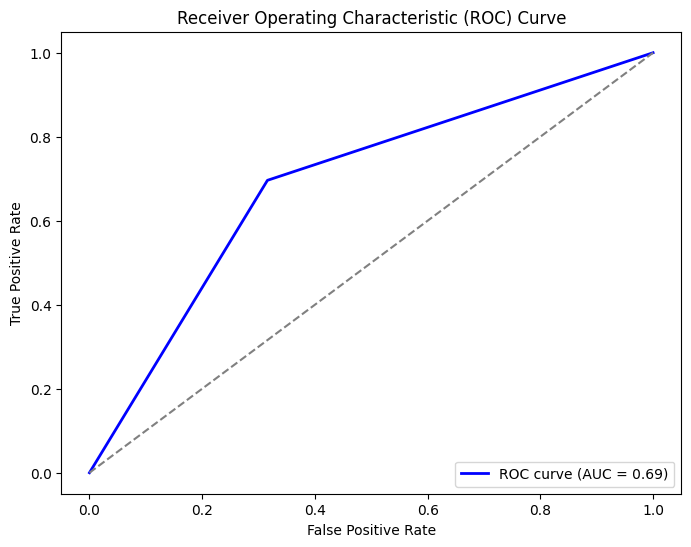

In [33]:

y_true = np.array(all_labels)
y_pred = np.array(all_preds)

accuracy = accuracy_score(y_true, y_pred)

precision = precision_score(y_true, y_pred)

recall = recall_score(y_true, y_pred)

f1 = f1_score(y_true, y_pred)

sensitivity = recall

specificity = recall_score(y_true, y_pred, pos_label=0)

auc = roc_auc_score(y_true, y_pred)

print("Evaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"AUC: {auc:.4f}")

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [10]:
%pip install matplotlib

     ---------------------------------------- 0.0/162.8 kB ? eta -:--:--
     ------- ------------------------------- 30.7/162.8 kB 1.4 MB/s eta 0:00:01
     -------------------------------------- 162.8/162.8 kB 3.2 MB/s eta 0:00:00
  Using cached pyparsing-3.1.2-py3-none-any.whl.metadata (5.1 kB)
   ---------------------------------------- 0.0/8.0 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.0 MB 9.9 MB/s eta 0:00:01
   --- ------------------------------------ 0.7/8.0 MB 7.2 MB/s eta 0:00:02
   ----- ---------------------------------- 1.1/8.0 MB 7.7 MB/s eta 0:00:01
   ------- -------------------------------- 1.5/8.0 MB 8.2 MB/s eta 0:00:01
   --------- ------------------------------ 2.0/8.0 MB 9.0 MB/s eta 0:00:01
   ------------ --------------------------- 2.5/8.0 MB 9.0 MB/s eta 0:00:01
   --------------- ------------------------ 3.1/8.0 MB 9.5 MB/s eta 0:00:01
   ------------------- -------------------- 3.8/8.0 MB 10.2 MB/s eta 0:00:01
   --------------------

In [17]:
import matplotlib.pyplot as plt

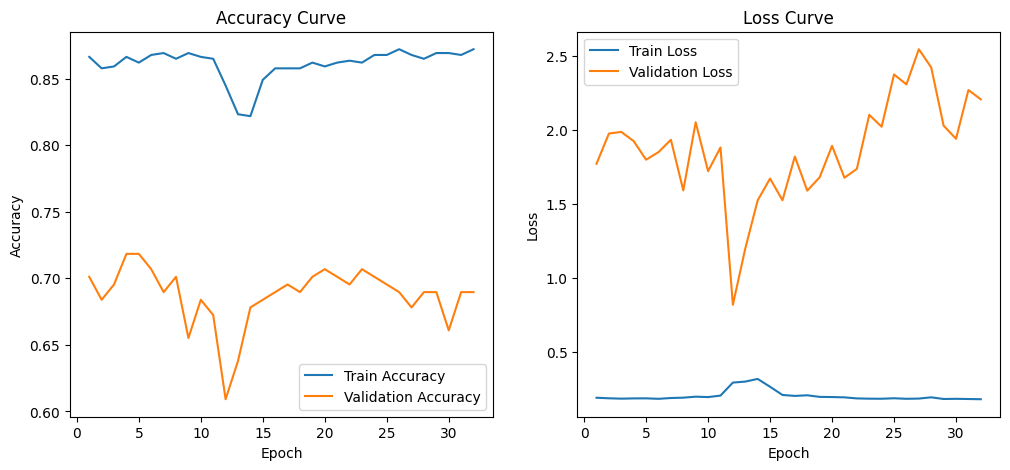

In [34]:
# Plotting the accuracy and loss curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

plt.show()

In [15]:
%pip install scikit-learn seaborn

   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   ---------------------- ----------------- 163.8/294.9 kB 3.3 MB/s eta 0:00:01
   ---------------------------------------- 294.9/294.9 kB 4.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/11.5 MB ? eta -:--:--
   -- ------------------------------------- 0.9/11.5 MB 27.4 MB/s eta 0:00:01
   ------ --------------------------------- 1.8/11.5 MB 28.9 MB/s eta 0:00:01
   ----------------- ---------------------- 5.1/11.5 MB 40.8 MB/s eta 0:00:01
   ----------------------------- ---------- 8.6/11.5 MB 49.7 MB/s eta 0:00:01
   ---------------------------------------  11.5/11.5 MB 59.5 MB/s eta 0:00:01
   ---------------------------------------- 11.5/11.5 MB 54.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/505.5 kB ? eta -:--:--
   ---------------------------------------- 505.5/505.5 kB ? eta 0:00:00
   ---------------------------------------- 0.0/345.4 kB ? eta -:--:--
   -----------

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

In [ ]:







hrnet_path = './models/hrnet'
hrnet_model = load_model(hrnet_path, compile=False)

hrnet_model.trainable = False

def build_classification_head(num_classes, input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    features = hrnet_model(inputs)
    pooled_features = layers.GlobalAveragePooling2D()(features)
    outputs = layers.Dense(num_classes, activation='sigmoid')(pooled_features)
    model = Model(inputs, outputs)
    return model

# Function to load images and labels from a directory
def load_dataset(dataset_dir):
    images = []
    labels = []

    # Iterate through the directory
    for class_name in os.listdir(dataset_dir):
        class_dir = os.path.join(dataset_dir, class_name)
        
        # Skip if not a directory
        if not os.path.isdir(class_dir):
            continue
        
        # Label encoding (assuming class names are cancer and non_cancer)
        label = 1 if class_name == 'cancer' else 0
        
        # Load images from the directory
        for filename in os.listdir(class_dir):
            image_path = os.path.join(class_dir, filename)
            image = cv2.imread(image_path)  # Read image using OpenCV
            image = cv2.resize(image, (256, 256))  # Resize image to match HRNet input size
            images.append(image)
            labels.append(label)

    # Convert lists to numpy arrays
    images = np.array(images)
    labels = np.array(labels)

    return images, labels


In [ ]:


# Load dataset and preprocess
dataset_dir = ''  # Replace with the path to your dataset directory
images, labels = load_dataset(dataset_dir)

# Preprocess images (normalize pixel values)
images = images.astype('float32') / 255.0

# Split dataset into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

# Define number of classes
num_classes = 2  # cancer and non_cancer
input_shape = (256, 256, 3)  # Assuming HRNet expects input images of size 256x256

# Build the classification model
model = build_classification_head(num_classes, input_shape)

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
batch_size = 32  # Adjust as needed
epochs = 10  # Adjust as needed

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_dataset = (
    train_dataset
    .batch(batch_size)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
val_dataset = (
    val_dataset
    .batch(batch_size)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

history = model.fit(train_dataset,
                    epochs=epochs,
                    validation_data=val_dataset)

# Evaluate the model
loss, accuracy = model.evaluate(val_dataset)
print(f'Validation loss: {loss}, Validation accuracy: {accuracy}')

# Save the trained model
model.save('oral_cancer_detection_model.h5')

# Make predictions on new data (optional)
# Placeholder code, replace with your prediction code
# new_data = ...
# predictions = model.predict(new_data)
